In [1]:
import os
import sys

sys.path.append(os.path.abspath("../../"))

%matplotlib inline
import matplotlib.pyplot as plt
import my_utils as utils
import numpy as np
import pandas as pd


plt.rcParams["figure.figsize"] = (10, 12)
plt.rcParams["figure.dpi"] = 96

BASE_PATH = os.path.join("results", "early_concat")
INSTRUCTERC_BASE_PATH = os.path.join("results", "InstructERC")

# Early concatenation

In diesem Abschnitt werden die erzielten Ergebnisse und das Early-Concatenation Modell weitergehend untersucht, um folgenden Forschungsfragen zu beantworten:
- Wie ist die performance auf IEMOCAP und MELD
- Gibt es Änderungen in der Klassifizierung im Vergleich zum normalen InstructERC
  - Wenn ja, welche?
- Was wird durch die Akustik erkannt?
  - Was wird nur durch Akustik erkannt?
  - Gibt es Verbesserungen in bestimmten Emotionen
- Kann das Modell das volle Potenzial aus beiden Modalitäten ausnutzen?
- Nutzt das Modell die neuen Feature?
- Hat das Vortraining einen Einfluss auf die Effektivität des Modells

## IEMOCAP



In [2]:
DATASET = "IEMOCAP"


def get_result_dataframe(dataset: str) -> pd.DataFrame:
    normal_path = os.path.join(BASE_PATH, dataset, "preds_test_normal.json")
    audio_path = os.path.join(BASE_PATH, dataset, "preds_test_audio_only.json")

    normal_df = utils.build_result_dataframe(normal_path)
    audio_df = utils.build_result_dataframe(audio_path)
    ierc_df = utils.get_instructerc_results(INSTRUCTERC_BASE_PATH, dataset)

    assert len(normal_df) == len(audio_df) == len(ierc_df)

    results = utils.merge_result_dataframes([normal_df, audio_df, ierc_df], ["normal", "audio", "ierc"])
    results = utils.extract_dialogue_information(results)

    return results


df_iemocap = get_result_dataframe(DATASET)
df_iemocap.head(3)

,input,output,target,input_audio,output_audio,input_ierc,output_ierc,utterance,dialogue_length,utterence_length
index,,,,,,,,,,
0,Now you are expert of sentiment and emotional ...,neutral,neutral,Now you are expert of sentiment and emotional ...,neutral,Now you are expert of sentiment and emotional ...,frustrated,"Hi, I need an ID.",1,5
1,Now you are expert of sentiment and emotional ...,neutral,neutral,Now you are expert of sentiment and emotional ...,excited,Now you are expert of sentiment and emotional ...,neutral,"ahh Yeah, this is the wrong line. I'm sorry. ...",2,26
2,Now you are expert of sentiment and emotional ...,frustrated,frustrated,Now you are expert of sentiment and emotional ...,frustrated,Now you are expert of sentiment and emotional ...,frustrated,"Okay, I'm sorry, but I just stood in this line...",3,21


In [3]:
df_iemocap["target"].value_counts()

target
neutral       384
frustrated    381
excited       299
sad           245
angry         170
happy         143
Name: count, dtype: int64

### Performance

Dafür wird der gewichtete F1 Score berechnet:
\begin{equation}
    F1 = 2\cdot\frac{precision\cdot recall}{precision + recall}
\end{equation}
Dieser wird für jedes Label berechnet und durch die Anzahl der label normalisiert.
Dadurch bekommt jedes Label, unabhängig von der Anzah, die selbe Gewichtung im Gesamtergebnis.

In [4]:
from sklearn.metrics import f1_score


labels = df_iemocap["target"].value_counts().index.to_list()

concat_model_f1 = f1_score(df_iemocap["target"], df_iemocap["output"], average="weighted", labels=labels)
audio_only_f1 = f1_score(df_iemocap["target"], df_iemocap["output_audio"], average="weighted", labels=labels)
text_only_f1 = f1_score(df_iemocap["target"], df_iemocap["output_ierc"], average="weighted", labels=labels)

print(f"F1-Score des Concatenation Modells: {100*concat_model_f1:.2f}")
print(f"F1-Score mit nur audio input: {100*audio_only_f1:.2f}")
print(f"F1-Score des Basismodells: {100*text_only_f1:.2f}")
print(f"Änderung: {(100*concat_model_f1 - 100*text_only_f1):.2f}")

F1-Score des Concatenation Modells: 69.93
F1-Score mit nur audio input: 44.19
F1-Score des Basismodells: 69.57
Änderung: 0.36


Betrachten wir uns nun die Confusion-Matrix des Concatination Modells.
In Klammern ist der prozentuale Anteil der Zeile angegeben. Daran orientiert sich ebenfalls auch die Farbgebung.

/home/fock/code/MultiModalInstructERC/.conda/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 7 x 7 in image.
/home/fock/code/MultiModalInstructERC/.conda/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: concat_iemocap_combined_cm.png


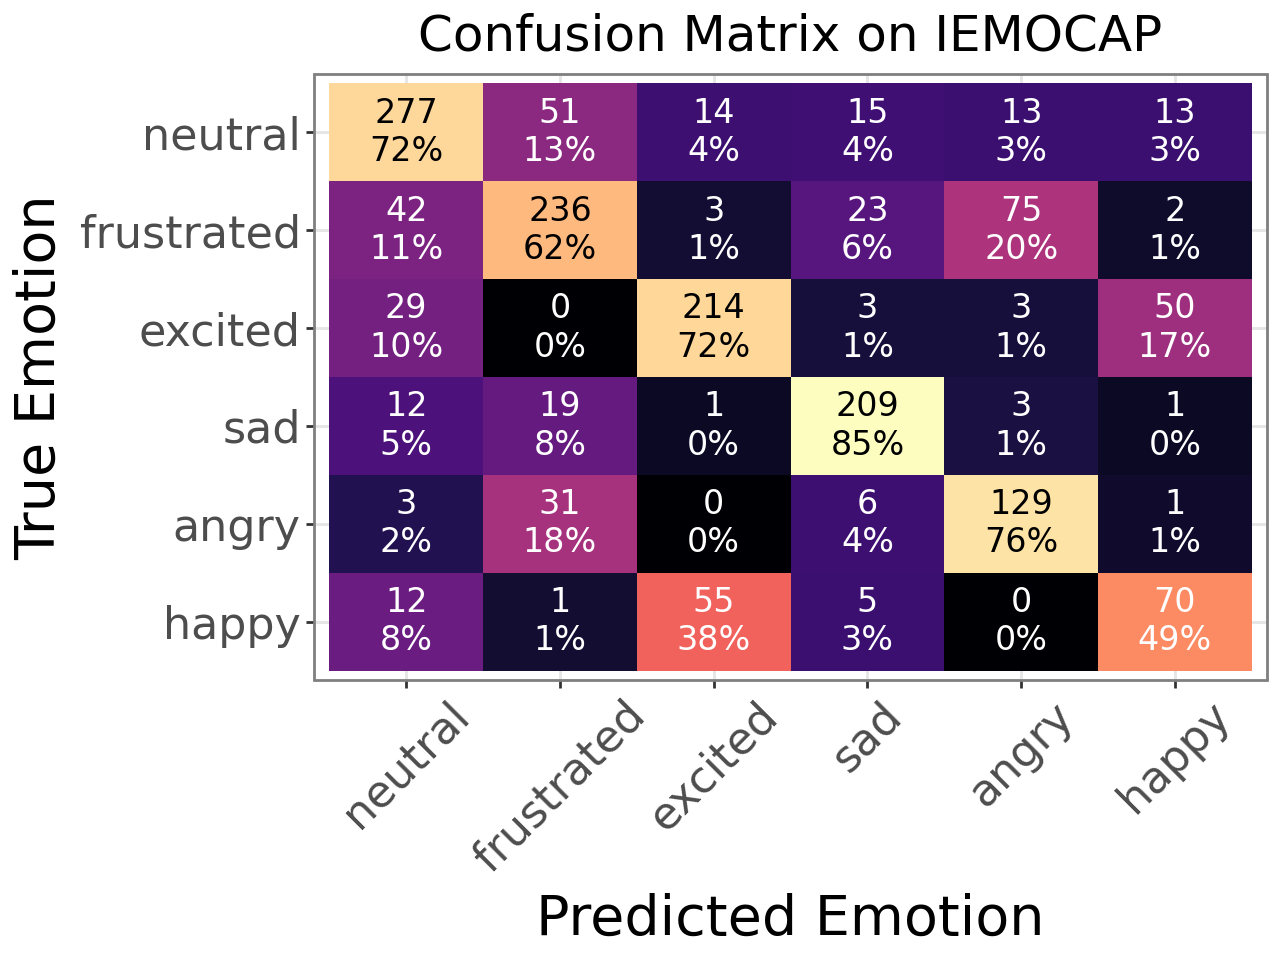

In [5]:
utils.print_confusion_matrix(df_iemocap, target_labels=labels[::-1], output_column="output", name = "concat_iemocap_combined_cm.png", title="Confusion Matrix on IEMOCAP")

Auffälligkeiten:
Es können entgegengesetzte Emotionen definiert werden. Die eine Klasse bilden die positiven Emotionen "happy" und "excited, die andere negative Emotionen "sad", "angry" und "frustrated".
Zwischen diesen beiden Gruppen gibt es so gut wie keine Verwechselungen, wie die Confusion-Matrix, mit einteilung in positiv und negativ, zeigt.

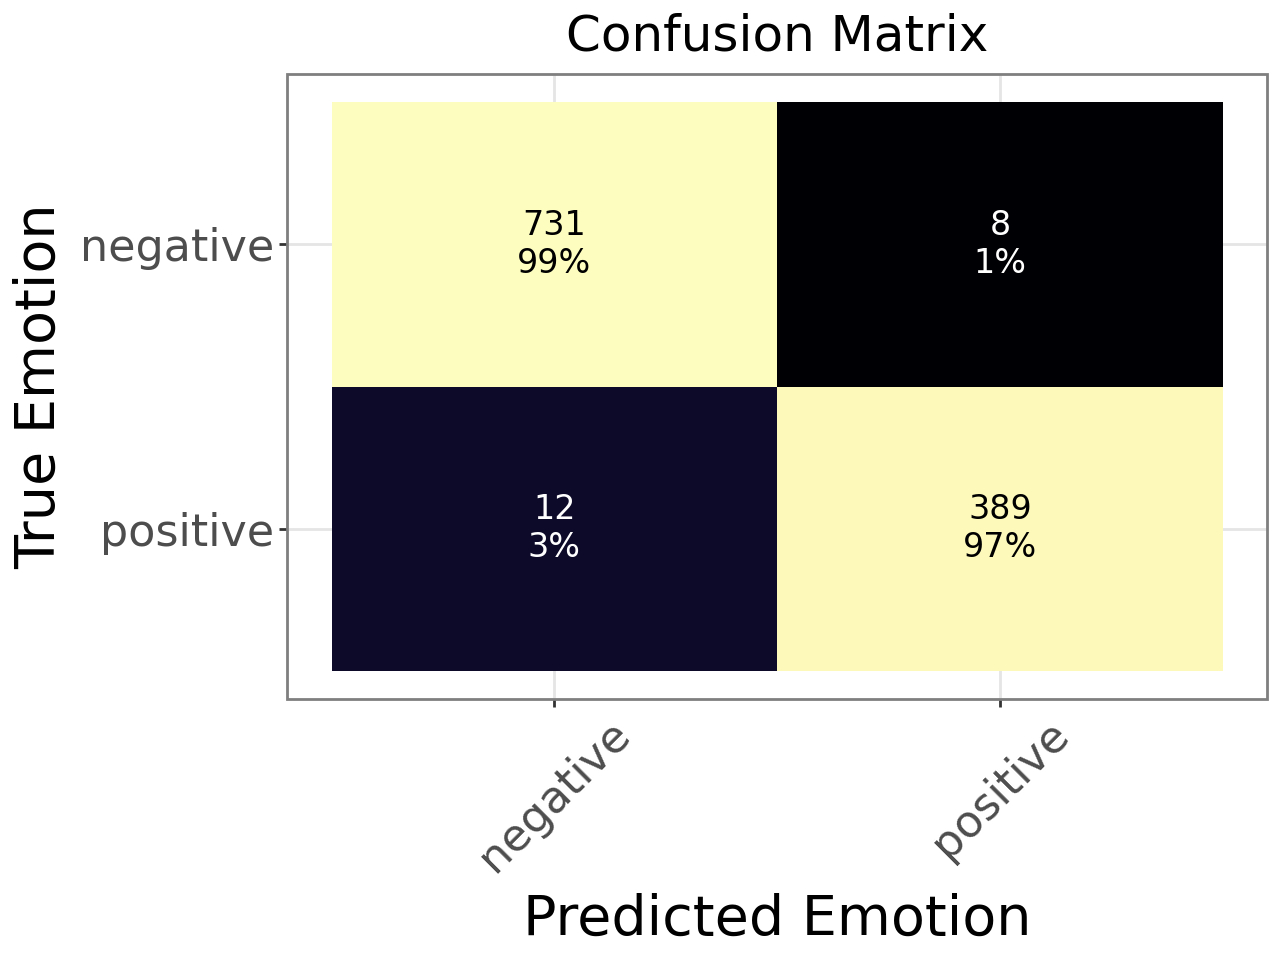

In [6]:
from functools import partial


iemocap_positive_emotions = ["happy", "excited"]
iemocap_negative_emotions = ["angry", "sad", "frustrated"]


iemocap_classify_sentiment = partial(utils.classify_sentiment, positive=iemocap_positive_emotions, negative=iemocap_negative_emotions)

df_iemocap["emotion_sentiment"] = df_iemocap["target"].apply(iemocap_classify_sentiment)
df_iemocap["emotion_sentiment_prediction"] = df_iemocap["output"].apply(iemocap_classify_sentiment)


utils.print_confusion_matrix(df_iemocap, target_labels=["positive", "negative"], output_column="emotion_sentiment_prediction", target_column="emotion_sentiment")

Insgesammt werden nur 20 von 1110 Beispiele, also $\sim$ 1,18% zwischen den Gruppen falsch zugeordnet.

Anders sieht es bei der Intra-Klassenverwechselung aus:

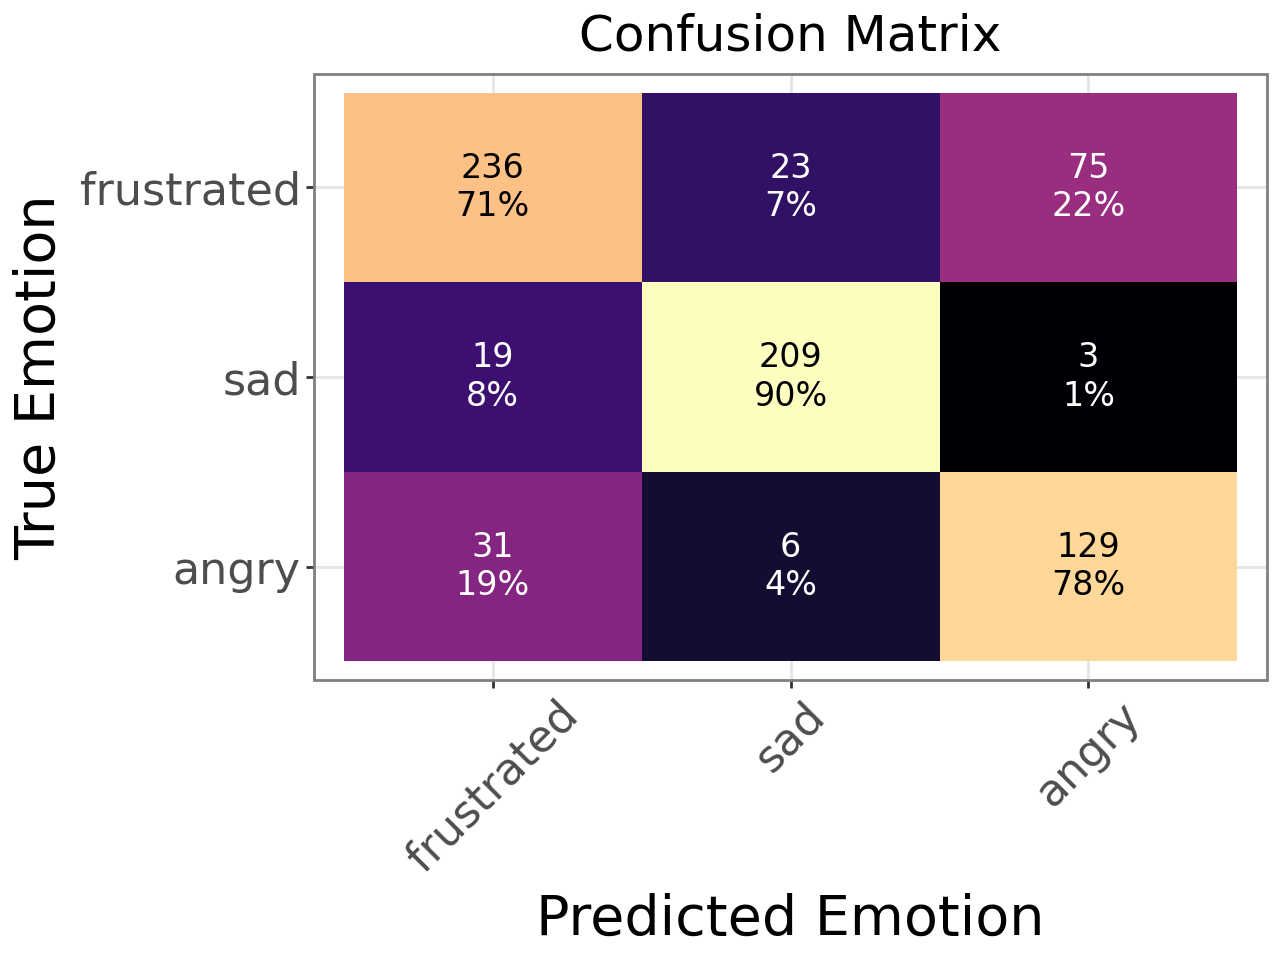

In [7]:
utils.print_confusion_matrix(
    df_iemocap,
    target_labels=iemocap_negative_emotions,
    output_column="output",
    target_column="target",
)

In den negativen Emotionen kommt es insbesondere bei Wut und Frustration zu Verwechselungen.
Trauer kann sehr gut von Wut auseinandergehalten werden, hier kommt es kaum zu Verwechselungen.

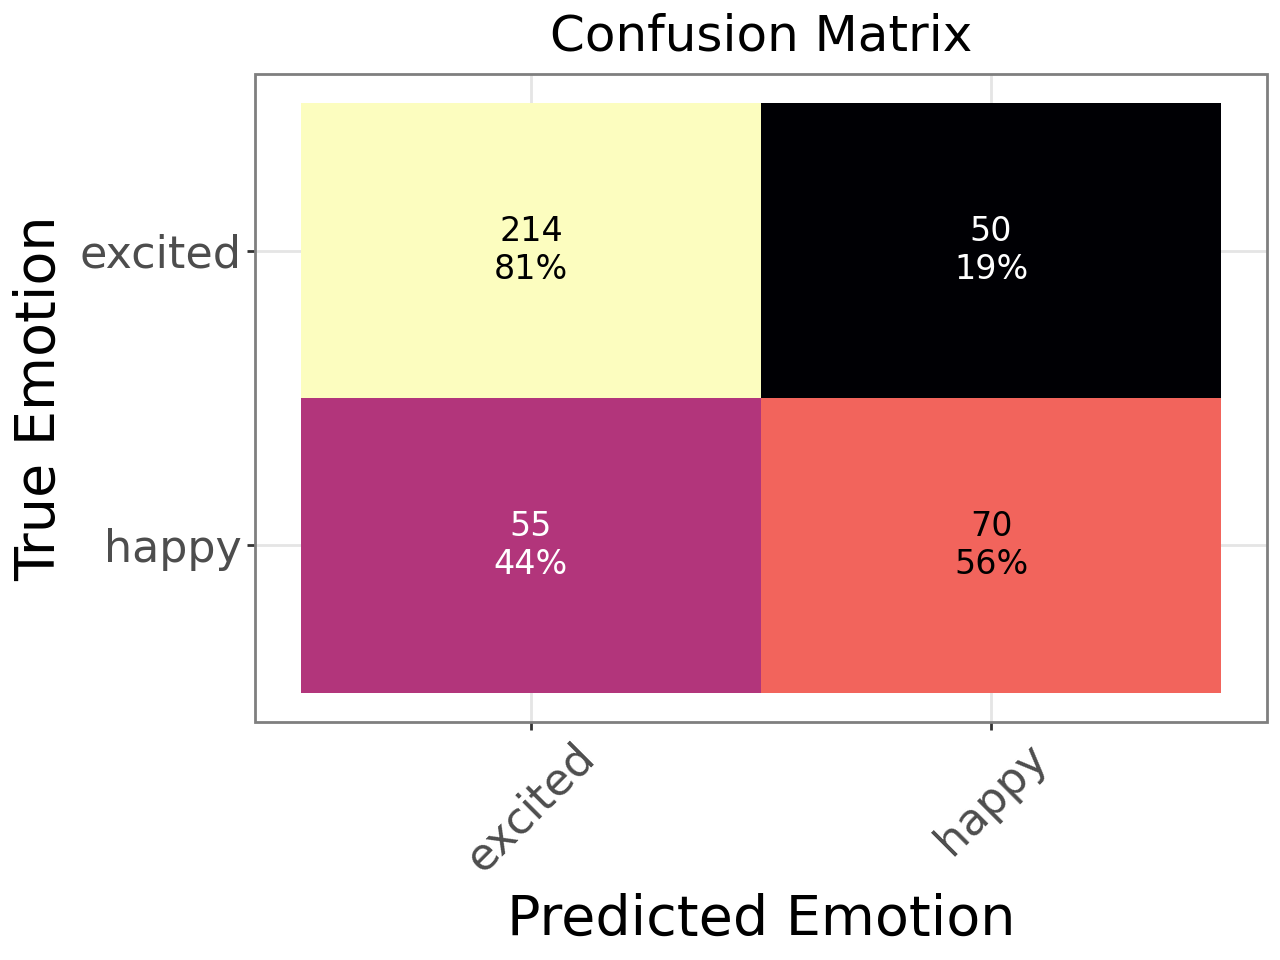

In [8]:
utils.print_confusion_matrix(
    df_iemocap,
    target_labels=iemocap_positive_emotions,
    output_column="output",
    target_column="target",
)

In der positiven Gruppe kommt es zu ähnlich häufigen Verwechselungen zwischen Aufgeregt udn Glücklich.
Zu beachten ist aber, dass "Glücklich" mit 143 Beispielen die am wenigsten vertretene Emotion im Datensatz.

TODO: Gucken, wie oft happy für excited von mindestens einem annotator vorgeschlagen wurde.

Weiter wird untersucht, worin die Veränderungen bestehen.
Geguckt wird, wieviele Beispiele jetzt nicht mehr erkannt werden und wie viele jetzt erkannt werden.

In [9]:
combined_model = df_iemocap["target"] == df_iemocap["output"]  # C
text_only_model = df_iemocap["target"] == df_iemocap["output_ierc"]  # T
audio_only_model = df_iemocap["target"] == df_iemocap["output_audio"]  # A

# Define negations
not_combined_model = ~combined_model
not_text_only_model = ~text_only_model
not_audio_only_model = ~audio_only_model

both_correct_but_not_text = df_iemocap[(combined_model) & (not_text_only_model)]
text_correct_but_not_both = df_iemocap[(text_only_model) & (not_combined_model)]


print(f"Nach dem Hinzufügen der Akustik können {len(both_correct_but_not_text)} Beispiele erkannt werden, die vorher nicht erkannt wurden")
print(f"Nach dem Hinzufügen der Akustik können {len(text_correct_but_not_both)} Beispiele nicht mehr richtig erkannt werden")

Nach dem Hinzufügen der Akustik können 172 Beispiele erkannt werden, die vorher nicht erkannt wurden
Nach dem Hinzufügen der Akustik können 165 Beispiele nicht mehr richtig erkannt werden


Es zeigt sich, dass das Modell fast so viele Beispiele nicht mehr richtig erkennt, wie es jetzt neu erkennt.
Dies erklärt den nur leicht gestiegenen F1-Score.


#### Veränderung der Emotionen

Wie sieht die Veränderung zwischen den Emotionen aus?
Dafür werden zuerst die F1-Scores im Vergleich vorher - nachher gezeigt, um zu sehen, ob es Veränderungen in den einzelnen Emotionen gab.

In [10]:
for label in labels:
    f1_label = f1_score(df_iemocap["target"], df_iemocap["output"], labels=[label], average="weighted") * 100
    f1_label_ierc = f1_score(df_iemocap["target"], df_iemocap["output_ierc"], labels=[label], average="weighted") * 100
    
    print(f"F1-Score für Label {label}: {f1_label:.2f} - Vorher: {f1_label_ierc:.2f} - Differenz: {(f1_label - f1_label_ierc):.2f}")

F1-Score für Label neutral: 72.99 - Vorher: 71.25 - Differenz: 1.74
F1-Score für Label frustrated: 65.65 - Vorher: 68.29 - Differenz: -2.64
F1-Score für Label excited: 73.04 - Vorher: 71.07 - Differenz: 1.97
F1-Score für Label sad: 82.61 - Vorher: 80.51 - Differenz: 2.10
F1-Score für Label angry: 65.65 - Vorher: 65.32 - Differenz: 0.33
F1-Score für Label happy: 50.00 - Vorher: 51.69 - Differenz: -1.69


Es gibt leichte Verbesserungen in den Klassen "neutral", "excited", "sad", während leichte Verschlechterungen in den Klassen "frustrated" und "happy" vorkommen.
"angry" hat einen nahezu gleichen Wert.

Als nächstes werden die Änderungen in der Confusion-Matrix analysiert.

/home/fock/code/MultiModalInstructERC/.conda/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 7 x 7 in image.
/home/fock/code/MultiModalInstructERC/.conda/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: concat_iemocap_diff_cm.png


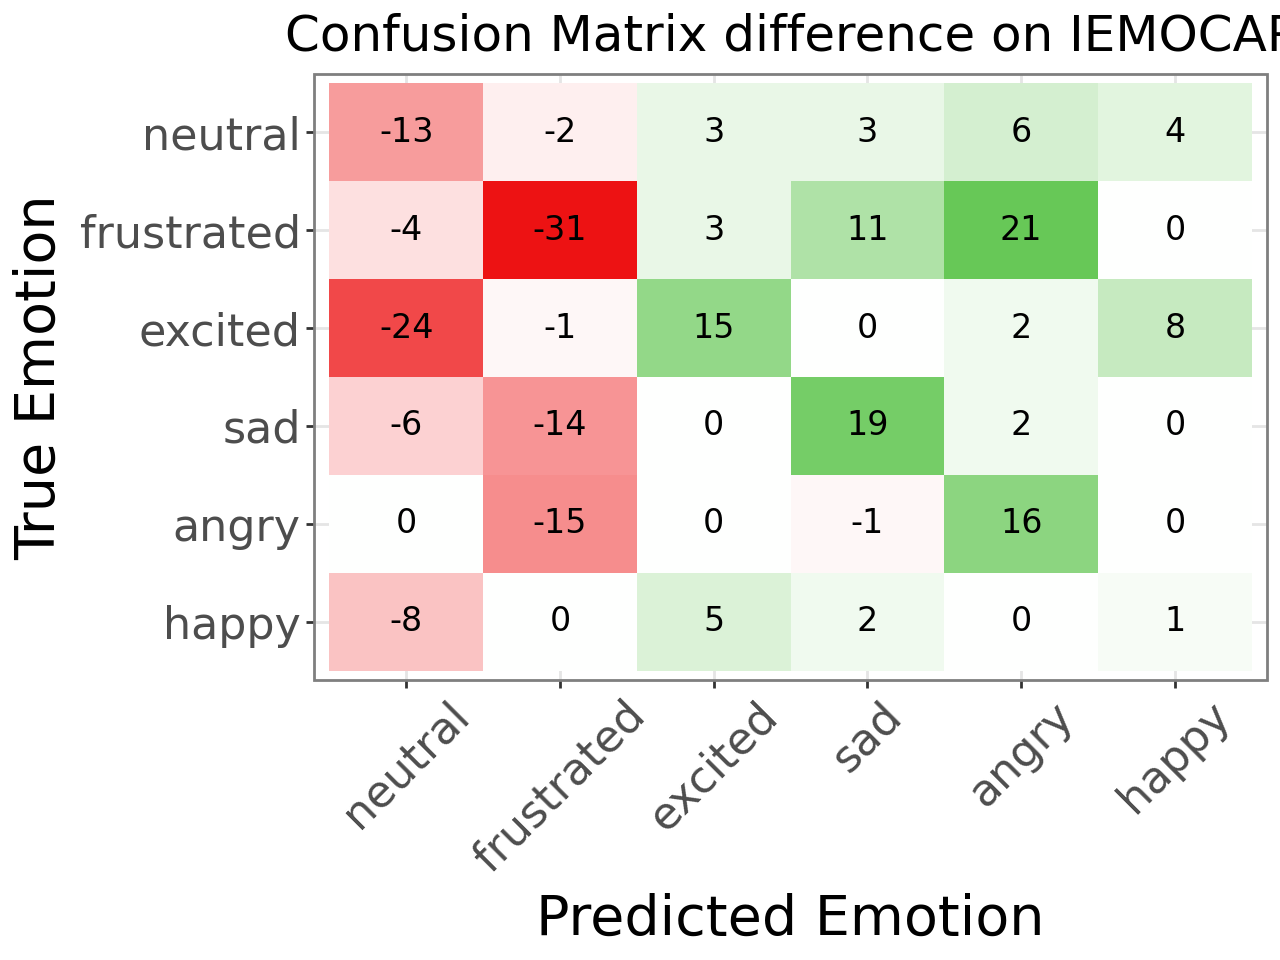

In [11]:
utils.print_confusion_matrix_difference(df_iemocap, target_labels=labels[::-1], output_column1="output", output_column2="output_ierc", name = "concat_iemocap_diff_cm.png", title="Confusion Matrix difference on IEMOCAP")

In [12]:
from sklearn.metrics import confusion_matrix

print(labels)
confusion_matrix(df_iemocap["target"], df_iemocap["output"], labels=labels) - confusion_matrix(df_iemocap["target"], df_iemocap["output_ierc"], labels=labels)

['neutral', 'frustrated', 'excited', 'sad', 'angry', 'happy']


array([[-13,  -2,   3,   3,   6,   4],
       [ -4, -31,   3,  11,  21,   0],
       [-24,  -1,  15,   0,   2,   8],
       [ -6, -14,   0,  19,   2,   0],
       [  0, -15,   0,  -1,  16,   0],
       [ -8,   0,   5,   2,   0,   1]])

In [13]:
from sklearn.metrics import precision_score, recall_score
for label in labels:
    y_true = df_iemocap["target"].apply(lambda x: 1 if x == label else 0)
    y_pred = df_iemocap["output"].apply(lambda x: 1 if x == label else 0)
    y_pred_ierc = df_iemocap["output_ierc"].apply(lambda x: 1 if x == label else 0)

    pre_label = precision_score(y_true, y_pred) * 100
    rec_label = recall_score(y_true, y_pred) * 100
    pre_label_ierc = precision_score(y_true, y_pred_ierc) * 100
    rec_label_ierc = recall_score(y_true, y_pred_ierc) * 100
    
    print(f"Precision\t für Label {label}: {pre_label:.2f} - Vorher: {pre_label_ierc:.2f} - Differenz: {(pre_label - pre_label_ierc):.2f}")
    print(f"Recall\t\t für Label {label}: {rec_label:.2f} - Vorher: {rec_label_ierc:.2f} - Differenz: {(rec_label - rec_label_ierc):.2f}")
    print()

Precision	 für Label neutral: 73.87 - Vorher: 67.44 - Differenz: 6.42
Recall		 für Label neutral: 72.14 - Vorher: 75.52 - Differenz: -3.39

Precision	 für Label frustrated: 69.82 - Vorher: 66.58 - Differenz: 3.24
Recall		 für Label frustrated: 61.94 - Vorher: 70.08 - Differenz: -8.14

Precision	 für Label excited: 74.56 - Vorher: 76.25 - Differenz: -1.68
Recall		 für Label excited: 71.57 - Vorher: 66.56 - Differenz: 5.02

Precision	 für Label sad: 80.08 - Vorher: 83.70 - Differenz: -3.62
Recall		 für Label sad: 85.31 - Vorher: 77.55 - Differenz: 7.76

Precision	 für Label angry: 57.85 - Vorher: 64.20 - Differenz: -6.36
Recall		 für Label angry: 75.88 - Vorher: 66.47 - Differenz: 9.41

Precision	 für Label happy: 51.09 - Vorher: 55.65 - Differenz: -4.55
Recall		 für Label happy: 48.95 - Vorher: 48.25 - Differenz: 0.70



Hier lässt sich erkennen, wie die Feränderungen in den F1-Scores zustandegekommen sind.
"Frustration" verliert am meisten Punkte, da es häufiger als "Wut" oder "Trauer" klassifiziert wird.
Dagegen werden "Trauer" und "Wut" jetzt weniger als "Frustration" klassifiziert, dafür häufiger korrekt.
Auch "Aufgeregt" kann nun besser zu einer neutralen Emotion differenziert werden.
Insgesamt kann besser zwischen "Neutral" / keine Emotion, und einer Emotionsklasse differenziert werden.

Wir gucken nun, ob das an der Akustik liegen kann.
- Dafür gucken wir uns die Verteilung von richtig klassifizierten Emotionen einmal aus dem "nur-Text" und einmal dem "nur-Audio" modell an.
- BEtrachten der Beispiele, die vorher falsch und jetzt richtig klassifiziert wurden. Gibt es bei der Akustik hier auch eine erhöhte Trefferrate?

In [14]:

text_only_false_but_now_correct = df_iemocap[(not_text_only_model) & (combined_model)]
text_only_false_but_audio_correct = df_iemocap[
    (not_text_only_model) & (audio_only_model)
]

correct_by_model_and_audio_but_not_text = df_iemocap[
    combined_model & audio_only_model & not_text_only_model
]

text_correct_but_not_audio_or_both = df_iemocap[
    text_only_model & not_audio_only_model & not_combined_model
]
text_correct_bot_not_audio = df_iemocap[text_only_model & not_audio_only_model]

print(
    f"Nach dem Hinzufügen der Akustik können {len(text_only_false_but_now_correct)} Beispiele erkannt werden, die vorher nicht erkannt wurden"
)
print(
    f"Die Akustik kann {len(text_only_false_but_audio_correct)} Beispiele erkennen, die vom Text allein nicht erkannt werden"
)
print(
    f"Insgesamt gibt es {len(correct_by_model_and_audio_but_not_text)} Beispiele, die nicht vom Text, aber vom Modell und der Akustik erkannt werden"
)
print(
    f"Insgesamt gibt es {len(text_correct_but_not_audio_or_both)} Beispiele, die nur vom Text, nicht aber vom Modell und der Akustik erkannt werden"
)
print(
    f"InstructERC kann {len(text_correct_bot_not_audio)} Beispiele richtig klassifizieren, die die Akustik nicht klassifizieren kann"
)

Nach dem Hinzufügen der Akustik können 172 Beispiele erkannt werden, die vorher nicht erkannt wurden
Die Akustik kann 172 Beispiele erkennen, die vom Text allein nicht erkannt werden
Insgesamt gibt es 76 Beispiele, die nicht vom Text, aber vom Modell und der Akustik erkannt werden
Insgesamt gibt es 101 Beispiele, die nur vom Text, nicht aber vom Modell und der Akustik erkannt werden
InstructERC kann 566 Beispiele richtig klassifizieren, die die Akustik nicht klassifizieren kann


Um zu gucken, ob die Akustik Anteile an der "positiven" Veränderung in der Klassifizierung hat, wird der Anteil der Emotionen berechnet aus der Untermenge der Beispiele, die nicht vom InstructERC Modell aber von der Akustik und dem gemischten Modell richtig klassifiziert werden konnten.

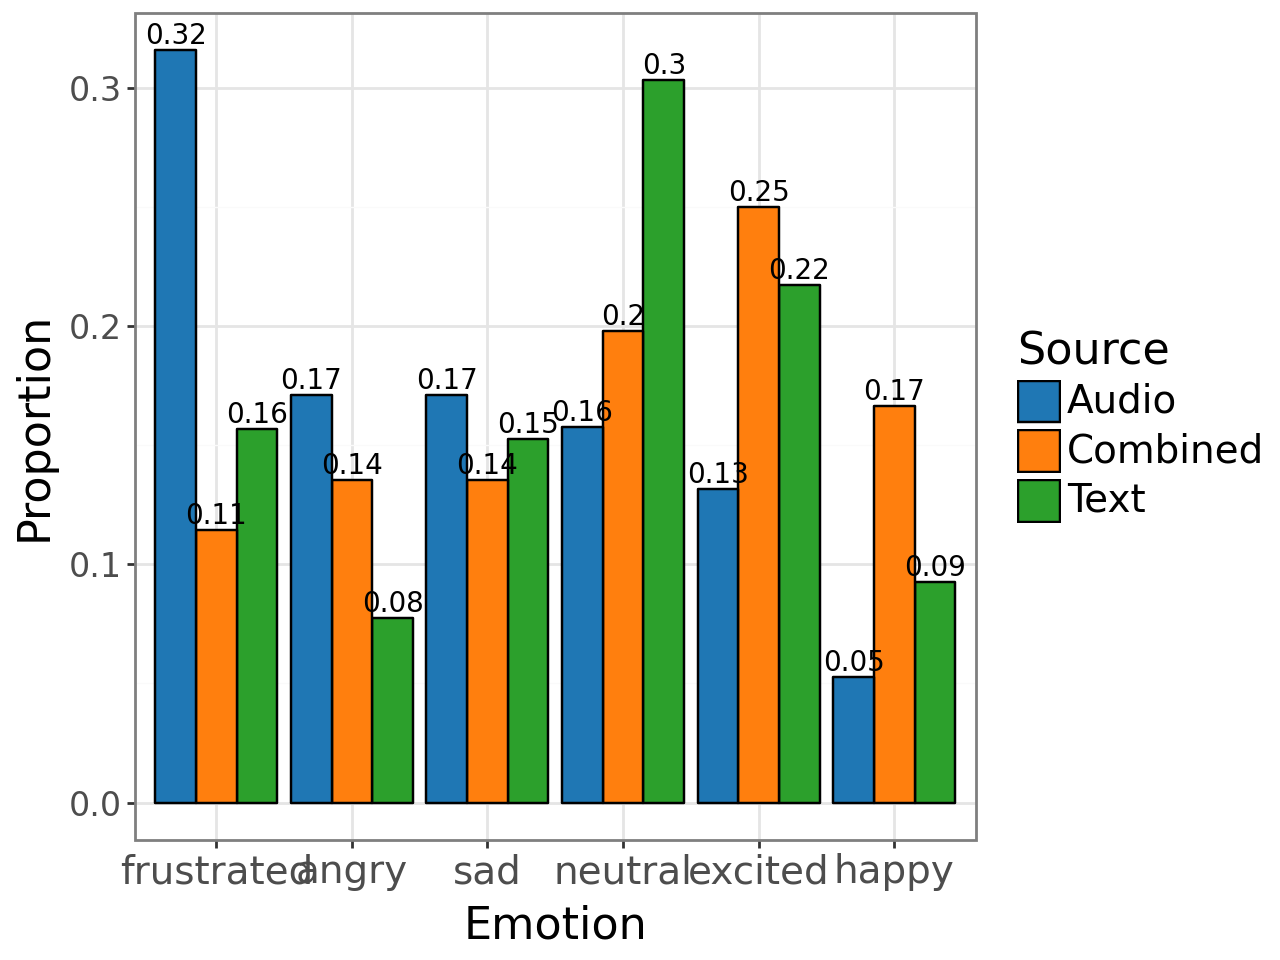

/home/fock/code/MultiModalInstructERC/.conda/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 10 x 5 in image.
/home/fock/code/MultiModalInstructERC/.conda/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: images/concat_iemocap_proportions.png


In [15]:
from plotnine import (
    aes,
    element_text,
    geom_col,
    geom_text,
    ggplot,
    labs,
    position_dodge,
    scale_fill_manual,
    theme,
    theme_bw,
    xlab,
    ylab,
    scale_fill_brewer
)

correct_by_model_and_audio_but_not_text = df_iemocap[
    (combined_model) & (not_text_only_model) & (audio_only_model)
]

correct_by_model_and_text_but_not_audio = df_iemocap[
    combined_model & not_audio_only_model & text_only_model
]

correct_by_model_only = df_iemocap[
    (combined_model) & (not_audio_only_model) & (not_text_only_model)
]


proportions = correct_by_model_and_audio_but_not_text.value_counts(
    "target", normalize=True
).to_frame(name="Audio")
proportions = (
    proportions.merge(
        correct_by_model_and_text_but_not_audio.value_counts(
            "target", normalize=True
        ).to_frame(name="Text"),
        how="outer",
        on="target",
    )
    .merge(
        correct_by_model_only.value_counts("target", normalize=True).to_frame(
            name="Combined"
        ),
        how="outer",
        on="target",
    )
    .reset_index()
)
proportions = proportions.melt(
    id_vars="target",
    value_vars=["Audio", "Text", "Combined"],
    var_name="source",
    value_name="proportion",
)

proportions["proportion"] = proportions["proportion"].fillna(0.0)
proportions["target"] = pd.Categorical(
    proportions["target"],
    categories=proportions[proportions["source"] == "Audio"].sort_values(
        by="proportion", ascending=False
    )["target"],
)


p = (
    ggplot(proportions, aes(x="factor(target)", y="proportion", fill="source"))
    + geom_col(position="dodge", color="black")
    + geom_text(
        aes(label="round(proportion, 2)"),
        va="bottom",
        position=position_dodge(0.9),
        size=10,
    )
    + ylab("Proportion")
    + xlab("Emotion")
    + labs(fill="Source")
    + theme_bw()
    + theme(
        axis_text_x=element_text(size=14),
        axis_text_y=element_text(size=12),
        axis_title=element_text(size=16),
        legend_text=element_text(size=14),
        legend_title=element_text(size=16),
    )
    + scale_fill_manual(values=["#1f77b4", "#ff7f0e", "#2ca02c"])
)

p.show()
p.save("images/concat_iemocap_proportions.png", width=10, height=5)
# proportions

Wir sahen verbesserungen im Bereich "Excited", "Sad" und "Angry". Anhand der Verteilung exklusiv richtig klassifizierten Emotionen zeigt sich, dass die Akustik große Stärken im Bereich "Frustration" besitzt.
Aber vorallem in den Klassen "Sad" und "Angry" ist die Akustik besser als der Text, was einen Hinweis liefert, dass durch die Hinzunahme der Akustik, diese Klassen besser differenziert werden konnten.

### Idealer F1 Score

In [145]:
df_iemocap["any_correct"] = df_iemocap[
    text_only_model | audio_only_model | combined_model
]["target"]
df_iemocap.loc[df_iemocap["any_correct"].isna(), "any_correct"] = df_iemocap.loc[
    df_iemocap["any_correct"].isna(), "output"
]

f1 = f1_score(df_iemocap["target"], df_iemocap["output"], average="weighted")
text_f1 = f1_score(df_iemocap["target"], df_iemocap["output_ierc"], average="weighted")
audio_f1 = f1_score(
    df_iemocap["target"], df_iemocap["output_audio"], average="weighted"
)
ideal_f1 = f1_score(df_iemocap["target"], df_iemocap["any_correct"], average="weighted")

print(f"Model F1 Score: {f1:.4f}")
print(f"Text F1 Score: {text_f1:.4f}")
print(f"Audio F1 Score: {audio_f1:.4f}")
print(f"Idealer F1 Score: {ideal_f1:.4f}")

Model F1 Score: 0.6993
Text F1 Score: 0.6957
Audio F1 Score: 0.4419
Idealer F1 Score: 0.8594


### Weitere Statistiken
Hier werden weitere Statistiken genannt, wie das Klassifizierungsverhalten der einzelnen Teilmodelle ist.
Es wurden einmal die Ergebnisse von InstructERC, dem Early-Concatination Modell mit Fenstergröße 1 und nur audio input, und dem Early-Concatination modell mit vollem Input berechnet.


In [146]:
both_correct = df_iemocap[combined_model]
both_not_correct = df_iemocap[not_combined_model]
text_correct = df_iemocap[text_only_model]
text_not_correct = df_iemocap[not_text_only_model]
text_correct_but_not_both = df_iemocap[text_only_model & not_combined_model]
both_correct_but_not_text = df_iemocap[combined_model & not_text_only_model]
text_and_both_correct = df_iemocap[text_only_model & combined_model]
text_and_both_not_correct = df_iemocap[not_text_only_model & not_combined_model]


print(f"Vom kombinierten modell konnten {len(both_correct)} Beispiele erkannt werden")
print(f"Vom kombinierten modell konnten {len(both_not_correct)} Beispiele nicht erkannt werden")
print(f"Vom Text konnten {len(text_correct)} Beispiele erkannt werden")
print(f"Vom Text konnten {len(text_not_correct)} Beispiele nicht erkannt werden")
print(f"Vom Text konnten {len(text_correct_but_not_both)} Beispiele erkannt werden, die nicht vom kombinierten erkannt wurden")
print(f"Vom kombinierten konnten {len(both_correct_but_not_text)} Beispiele erkannt werden, die nicht vom text erkannt wurden")
print(f"Vom Text und kombinierten konnten {len(text_and_both_correct)} gemiensame Beispiele erkannt werden")

Vom kombinierten modell konnten 1135 Beispiele erkannt werden
Vom kombinierten modell konnten 487 Beispiele nicht erkannt werden
Vom Text konnten 1128 Beispiele erkannt werden
Vom Text konnten 494 Beispiele nicht erkannt werden
Vom Text konnten 165 Beispiele erkannt werden, die nicht vom kombinierten erkannt wurden
Vom kombinierten konnten 172 Beispiele erkannt werden, die nicht vom text erkannt wurden
Vom Text und kombinierten konnten 963 gemiensame Beispiele erkannt werden


In [147]:
# Existing statistics
text_correct_bot_not_audio = df_iemocap[(text_only_model) & (not_audio_only_model)]
audio_only_correct = df_iemocap[(not_text_only_model) & (audio_only_model)]
both_only_correct = df_iemocap[
    (combined_model) & (not_audio_only_model) & (not_text_only_model)
]
text_correct_but_not_both = df_iemocap[(text_only_model) & (not_combined_model)]
audio_correct_but_not_both = df_iemocap[(audio_only_model) & (not_combined_model)]
text_correct_but_not_audio_and_both = df_iemocap[
    (text_only_model) & (not_audio_only_model) & (not_combined_model)
]
audio_correct_but_not_text_and_both = df_iemocap[
    (audio_only_model) & (not_text_only_model) & (not_combined_model)
]

# Print existing statistics
print(
    f"Es konnten {len(text_correct_bot_not_audio)} Datenpunkte nur vom text-only Modell erkannt werden, nicht aber vom audio-only."
)
print(
    f"Es konnten {len(audio_only_correct)} Datenpunkte nur vom audio-only Modell erkannt werden, nicht aber vom text-only."
)
print(
    f"Es konnten {len(both_only_correct)} Datenpunkte nur durch gemeinsamen Input erkannt werden."
)
print(
    f"Es konnten {len(text_correct_but_not_both)} Datenpunkte nur durch text-only erkannt werden, nicht aber durch gemeinsamen Input."
)
print(
    f"Es konnten {len(audio_correct_but_not_both)} Datenpunkte nur durch audio-only erkannt werden, nicht aber durch gemeinsamen Input."
)
print(
    f"Es konnten {len(text_correct_but_not_audio_and_both)} Datenpunkte nur durch text-only erkannt werden, aber weder durch audio-only noch durch gemeinsamen Input."
)
print(
    f"Es konnten {len(audio_correct_but_not_text_and_both)} Datenpunkte nur durch audio-only erkannt werden, aber weder durch text-only noch durch gemeinsamen Input."
)

# Additional statistics

# 1. Alle Modelle haben die Zielvorhersage korrekt erkannt
all_correct = df_iemocap[(text_only_model) & (audio_only_model) & (combined_model)]
print(
    f"Es konnten {len(all_correct)} Datenpunkte von allen Modellen korrekt erkannt werden. (Schnittmenge)"
)

# 2. Keines der Modelle hat die Zielvorhersage korrekt erkannt
all_incorrect = df_iemocap[
    (not_text_only_model) & (not_audio_only_model) & (not_combined_model)
]
print(
    f"Es konnten {len(all_incorrect)} Datenpunkte von keinem Modell korrekt erkannt werden."
)

# 3. Text-only und Audio-only Modelle sind korrekt, aber das kombinierte Modell ist falsch
text_and_audio_correct_but_not_combined = df_iemocap[
    (text_only_model) & (audio_only_model) & (not_combined_model)
]
print(
    f"Es konnten {len(text_and_audio_correct_but_not_combined)} Datenpunkte nur durch text-only und audio-only korrekt erkannt werden, aber nicht durch gemeinsamen Input."
)

# 4. Text-only und kombiniert Modelle sind korrekt, aber das Audio-only Modell ist falsch
text_and_combined_correct_but_not_audio = df_iemocap[
    (text_only_model) & (combined_model) & (not_audio_only_model)
]
print(
    f"Es konnten {len(text_and_combined_correct_but_not_audio)} Datenpunkte nur durch text-only und gemeinsamen Input korrekt erkannt werden, aber nicht durch audio-only."
)

# 5. Audio-only und kombiniert Modelle sind korrekt, aber das Text-only Modell ist falsch
audio_and_combined_correct_but_not_text = df_iemocap[
    (audio_only_model) & (combined_model) & (not_text_only_model)
]
print(
    f"Es konnten {len(audio_and_combined_correct_but_not_text)} Datenpunkte nur durch audio-only und gemeinsamen Input korrekt erkannt werden, aber nicht durch text-only."
)

not_combined_but_text_or_audio = df_iemocap[
    (not_combined_model) & ((text_only_model) | (audio_only_model))
]

print(
    f"Es konnten {len(not_combined_but_text_or_audio)} Datenpunkte nicht durch gemeinsamen Input erkannt werden, obwohl entweder audio-only oder text-only es erkennen konnten"
)

Es konnten 566 Datenpunkte nur vom text-only Modell erkannt werden, nicht aber vom audio-only.
Es konnten 172 Datenpunkte nur vom audio-only Modell erkannt werden, nicht aber vom text-only.
Es konnten 96 Datenpunkte nur durch gemeinsamen Input erkannt werden.
Es konnten 165 Datenpunkte nur durch text-only erkannt werden, nicht aber durch gemeinsamen Input.
Es konnten 160 Datenpunkte nur durch audio-only erkannt werden, nicht aber durch gemeinsamen Input.
Es konnten 101 Datenpunkte nur durch text-only erkannt werden, aber weder durch audio-only noch durch gemeinsamen Input.
Es konnten 96 Datenpunkte nur durch audio-only erkannt werden, aber weder durch text-only noch durch gemeinsamen Input.
Es konnten 498 Datenpunkte von allen Modellen korrekt erkannt werden. (Schnittmenge)
Es konnten 226 Datenpunkte von keinem Modell korrekt erkannt werden.
Es konnten 64 Datenpunkte nur durch text-only und audio-only korrekt erkannt werden, aber nicht durch gemeinsamen Input.
Es konnten 465 Datenpunkt

#### 1. **Leistung der einzelnen Modelle:**
- **Text-only Modell:**
  - Es konnten **566 Datenpunkte** korrekt erkannt werden, die das audio-only Modell nicht richtig klassifiziert hat.
  - **101 Datenpunkte** wurden nur durch das text-only Modell korrekt erkannt, weder durch das audio-only noch durch das kombinierte Modell.
  - **465 Datenpunkte** wurden sowohl vom text-only Modell als auch vom kombinierten Modell richtig klassifiziert, jedoch nicht vom audio-only Modell.

  **Interpretation:** Das text-only Modell ist deutlich dominierend und kann viele Datenpunkte richtig klassifizieren, bei denen das audio-only Modell scheitert. 
  

- **Audio-only Modell:**
  - **172 Datenpunkte** wurden vom audio-only Modell korrekt erkannt, jedoch nicht vom text-only Modell.
  - **96 Datenpunkte** wurden nur vom audio-only Modell korrekt erkannt, aber weder vom text-only Modell noch vom kombinierten Modell.
  - **76 Datenpunkte** wurden sowohl vom audio-only als auch vom kombinierten Modell richtig erkannt, jedoch nicht vom text-only Modell.

  **Interpretation:** Das audio-only Modell kann Datenpunkte erkennen, die für das text-only Modell schwer zugänglich sind, jedoch insgesamt deutlich weniger als das text-only Modell. Die Tatsache, dass nur **96 Datenpunkte** von **172** Datenpunkten korrekt vom gemeinsamen Modell erkannt wurden, zwiegt, dass die Stärken der Akustik nicht gut ausgespielt werden.

#### 2. **Leistung des kombinierten Modells:**
- **498 Datenpunkte** wurden von allen Modellen (Text, Audio und kombiniert) korrekt erkannt, was auf eine solide Übereinstimmung zwischen den einzelnen Modalitäten hindeutet.
- **96 Datenpunkte** wurden nur vom kombinierten Modell korrekt erkannt, was darauf hindeutet, dass die Kombination der Modalitäten in bestimmten Fällen zu besseren Ergebnissen führt, wenn beide Einzelmodalitäten nicht ausreichen.
- Es gibt **226 Datenpunkte**, bei denen keines der Modelle korrekt war, was auf die Schwierigkeit dieser Fälle hindeutet, unabhängig von der verwendeten Modalität.

  **Interpretation:** Das kombinierte Modell kann die Stärken der beiden Modalitäten ausnutzen, insbesondere in den Fällen, in denen eine Modalität allein nicht ausreicht. Es gibt jedoch auch Fälle, in denen das kombinierte Modell schlechter abschneidet, zum Beispiel bei den **64 Datenpunkten**, die durch text-only und audio-only korrekt waren, jedoch nicht durch den kombinierten Input. Dies deutet darauf hin, dass die Fusion der Modalitäten in bestimmten Situationen nicht immer vorteilhaft ist.

#### 3. **Vergleich der Modalitäten:**
- **Text vs. Audio:**
  - Das text-only Modell zeigt insgesamt eine deutlich höhere Erkennungsrate als das audio-only Modell. Insbesondere bei den **566 Datenpunkten**, die nur durch Text erkannt wurden, wird der große Einfluss von textbasierten Informationen auf das Ergebnis klar.
  - Das audio-only Modell ist jedoch in der Lage, **172 Datenpunkte** zu erkennen, die das text-only nicht erkennt und **96 Datenpunkte**, die Text-only und das kombinierte Modell nicht korrekt vorhersagen konnten. Dies verdeutlicht, dass es Fälle gibt, in denen akustische Informationen entscheidend sind, das Modell aber nicht in der Lage ist diese Informationen auszunutzen.

- **Kombination der Modalitäten:**
  - Die Kombination von Text und Audio führt zu einer verbesserten Leistung in **96 Fällen**, in denen weder das text-only noch das audio-only Modell alleine erfolgreich war. Dies zeigt den Vorteil eines multimodalen Ansatzes.
  - Allerdings gibt es auch **64 Fälle**, in denen das kombinierte Modell scheitert, obwohl sowohl das Text- als auch das Audio-Modell korrekt waren. Dies könnte darauf hindeuten, dass die Fusion der beiden Modalitäten in diesen Fällen zu einer Informationsüberladung oder zu Konflikten führt.

#### 4. **Stärken und Schwächen der Teilmodelle:**
- Das **text-only Modell** zeigt insgesamt eine hohe Robustheit und liefert die besten Ergebnisse in den meisten Fällen. Es hat den Vorteil Semantik und den vorangegangenen Dialog mit in die Entscheidung einzubeziehen. 
- Das **audio-only Modell** zeigt seine Stärke in speziellen Fällen, in denen akustische Merkmale entscheidend sind. In diesen Fällen kann es Datenpunkte erkennen, die dem text-only Modell verborgen bleiben.
- Das **kombinierte Modell** zeigt seine Stärke besonders in Fällen, in denen die Modalitäten sich gegenseitig ergänzen. In den **96 Fällen**, in denen das kombinierte Modell allein richtig liegt, wird deutlich, dass die Fusion der Modalitäten in komplexeren Situationen von Vorteil ist. Allerdings gibt es auch Fälle, in denen die Kombination zu schlechteren Ergebnissen führt, was auf mögliche Interferenzen oder falsche Gewichtungen zwischen den Modalitäten hinweisen könnte.


In [148]:
# 1. Combined Model (C)
df_C = df_iemocap[combined_model]
print(f"In total, {len(df_C)} samples were recognized by the combined model.")

# 2. Text-Only Model (T)
df_T = df_iemocap[text_only_model]
print(f"In total, {len(df_T)} samples were recognized by the text-only model.")

# 3. Audio-Only Model (A)
df_A = df_iemocap[audio_only_model]
print(f"In total, {len(df_A)} samples were recognized by the audio-only model.")

# 4. NOT Combined Model (¬C)
df_not_C = df_iemocap[not_combined_model]
print(f"In total, {len(df_not_C)} samples were NOT recognized by the combined model.")

# 5. NOT Text-Only Model (¬T)
df_not_T = df_iemocap[not_text_only_model]
print(f"In total, {len(df_not_T)} samples were NOT recognized by the text-only model.")

# 6. NOT Audio-Only Model (¬A)
df_not_A = df_iemocap[not_audio_only_model]
print(f"In total, {len(df_not_A)} samples were NOT recognized by the audio-only model.")

# 7. Combined AND Text-Only Models (C ∧ T)
df_C_and_T = df_iemocap[combined_model & text_only_model]
print(f"In total, {len(df_C_and_T)} samples were recognized by both the combined and text-only models.")

# 8. Combined AND Audio-Only Models (C ∧ A)
df_C_and_A = df_iemocap[combined_model & audio_only_model]
print(f"In total, {len(df_C_and_A)} samples were recognized by both the combined and audio-only models.")

# 9. Text-Only AND Audio-Only Models (T ∧ A)
df_T_and_A = df_iemocap[text_only_model & audio_only_model]
print(f"In total, {len(df_T_and_A)} samples were recognized by both the text-only and audio-only models.")

# 10. Combined AND NOT Text-Only Models (C ∧ ¬T)
df_C_and_not_T = df_iemocap[combined_model & not_text_only_model]
print(f"In total, {len(df_C_and_not_T)} samples were recognized by the combined model but NOT by the text-only model.")

# 11. Combined AND NOT Audio-Only Models (C ∧ ¬A)
df_C_and_not_A = df_iemocap[combined_model & not_audio_only_model]
print(f"In total, {len(df_C_and_not_A)} samples were recognized by the combined model but NOT by the audio-only model.")

# 12. Text-Only AND NOT Combined Models (T ∧ ¬C)
df_T_and_not_C = df_iemocap[text_only_model & not_combined_model]
print(f"In total, {len(df_T_and_not_C)} samples were recognized by the text-only model but NOT by the combined model.")

# 13. Text-Only AND NOT Audio-Only Models (T ∧ ¬A)
df_T_and_not_A = df_iemocap[text_only_model & not_audio_only_model]
print(f"In total, {len(df_T_and_not_A)} samples were recognized by the text-only model but NOT by the audio-only model.")

# 14. Audio-Only AND NOT Combined Models (A ∧ ¬C)
df_A_and_not_C = df_iemocap[audio_only_model & not_combined_model]
print(f"In total, {len(df_A_and_not_C)} samples were recognized by the audio-only model but NOT by the combined model.")

# 15. Audio-Only AND NOT Text-Only Models (A ∧ ¬T)
df_A_and_not_T = df_iemocap[audio_only_model & not_text_only_model]
print(f"In total, {len(df_A_and_not_T)} samples were recognized by the audio-only model but NOT by the text-only model.")

# 16. NOT Combined AND NOT Text-Only Models (¬C ∧ ¬T)
df_not_C_and_not_T = df_iemocap[not_combined_model & not_text_only_model]
print(f"In total, {len(df_not_C_and_not_T)} samples were NOT recognized by both the combined and text-only models.")

# 17. NOT Combined AND NOT Audio-Only Models (¬C ∧ ¬A)
df_not_C_and_not_A = df_iemocap[not_combined_model & not_audio_only_model]
print(f"In total, {len(df_not_C_and_not_A)} samples were NOT recognized by both the combined and audio-only models.")

# 18. NOT Text-Only AND NOT Audio-Only Models (¬T ∧ ¬A)
df_not_T_and_not_A = df_iemocap[not_text_only_model & not_audio_only_model]
print(f"In total, {len(df_not_T_and_not_A)} samples were NOT recognized by both the text-only and audio-only models.")

# 19. Combined AND Text-Only AND Audio-Only Models (C ∧ T ∧ A)
df_C_and_T_and_A = df_iemocap[combined_model & text_only_model & audio_only_model]
print(f"In total, {len(df_C_and_T_and_A)} samples were recognized by the combined, text-only, and audio-only models.")

# 20. Combined AND Text-Only AND NOT Audio-Only Models (C ∧ T ∧ ¬A)
df_C_and_T_and_not_A = df_iemocap[combined_model & text_only_model & not_audio_only_model]
print(f"In total, {len(df_C_and_T_and_not_A)} samples were recognized by the combined and text-only models but NOT by the audio-only model.")

# 21. Combined AND NOT Text-Only AND Audio-Only Models (C ∧ ¬T ∧ A)
df_C_and_not_T_and_A = df_iemocap[combined_model & not_text_only_model & audio_only_model]
print(f"In total, {len(df_C_and_not_T_and_A)} samples were recognized by the combined and audio-only models but NOT by the text-only model.")

# 22. Combined AND NOT Text-Only AND NOT Audio-Only Models (C ∧ ¬T ∧ ¬A)
df_C_and_not_T_and_not_A = df_iemocap[combined_model & not_text_only_model & not_audio_only_model]
print(f"In total, {len(df_C_and_not_T_and_not_A)} samples were recognized by the combined model but NOT by the text-only and audio-only models.")

# 23. NOT Combined AND Text-Only AND Audio-Only Models (¬C ∧ T ∧ A)
df_not_C_and_T_and_A = df_iemocap[not_combined_model & text_only_model & audio_only_model]
print(f"In total, {len(df_not_C_and_T_and_A)} samples were NOT recognized by the combined model but recognized by both the text-only and audio-only models.")

# 24. NOT Combined AND Text-Only AND NOT Audio-Only Models (¬C ∧ T ∧ ¬A)
df_not_C_and_T_and_not_A = df_iemocap[not_combined_model & text_only_model & not_audio_only_model]
print(f"In total, {len(df_not_C_and_T_and_not_A)} samples were NOT recognized by the combined and audio-only models but recognized by the text-only model.")

# 25. NOT Combined AND NOT Text-Only AND Audio-Only Models (¬C ∧ ¬T ∧ A)
df_not_C_and_not_T_and_A = df_iemocap[not_combined_model & not_text_only_model & audio_only_model]
print(f"In total, {len(df_not_C_and_not_T_and_A)} samples were NOT recognized by the combined and text-only models but recognized by the audio-only model.")

# 26. NOT Combined AND NOT Text-Only AND NOT Audio-Only Models (¬C ∧ ¬T ∧ ¬A)
df_not_C_and_not_T_and_not_A = df_iemocap[not_combined_model & not_text_only_model & not_audio_only_model]
print(f"In total, {len(df_not_C_and_not_T_and_not_A)} samples were NOT recognized by the combined, text-only, and audio-only models.")


In total, 1135 samples were recognized by the combined model.
In total, 1128 samples were recognized by the text-only model.
In total, 734 samples were recognized by the audio-only model.
In total, 487 samples were NOT recognized by the combined model.
In total, 494 samples were NOT recognized by the text-only model.
In total, 888 samples were NOT recognized by the audio-only model.
In total, 963 samples were recognized by both the combined and text-only models.
In total, 574 samples were recognized by both the combined and audio-only models.
In total, 562 samples were recognized by both the text-only and audio-only models.
In total, 172 samples were recognized by the combined model but NOT by the text-only model.
In total, 561 samples were recognized by the combined model but NOT by the audio-only model.
In total, 165 samples were recognized by the text-only model but NOT by the combined model.
In total, 566 samples were recognized by the text-only model but NOT by the audio-only mode

## Attention-Weights

Um zu untersuchen, ob das training effektiv und das Modell die zusätzlichen feature tatsächlich verwendet, untersuchen wir die Attention-Weight Matrix.
Diese gibt aufschluss darüber, worauf sich das Modell konzentriert.
Zur erinnerung, die Attention-Matrix ist eine $T_x \times T_x$ Matrix, wobei $T_x$ für die Länge der Eingabesequenz steht.
Diese ist besitzt nur im unteren linken Dreieck $\{A_{i,j} \mid i \ge j\}$ Werte, während alle anderen 0 betragen.
Eine Begründung dafür steht in Abschnitt (ref...).
Jede Zeile enthält das Attenntion-Query Ergebnis eines Query-Vektors, während die Spalten die Ergebnisse der Keys representiert.
Zu interpretieren ist also eine Zeile, dass sich aus der neue Kontext-Vektor für den Token zu prozentualen Anteilen zusammensetzt, wie diese in der Zeile stehen.
Währenddessen zeigt jede Zeile, wie stark ein gegebener Token zum nächsten Zustand beigetragen hat.
Befinden sich in einer Spalte nur niedrige Werte, hat dieser Token wenig zum Ergebnisausgang beigetragen.

Wenn man also überprüfen möchte, ob das Netz die akustischen Feature tatsächlich verwendet, sollte es keine besonderen Auffälligkeiten oder erhöhte Werte in den Spalten der Audio-Token geben.

In [149]:
import torch
from transformers import AutoTokenizer

from utils.collator import SequenceGenerationCollator
from utils.model import MmLlamaConcat, MmLlamaConfig
from utils.processor import MmLlamaProcessor

In [150]:
LANGUAGE_MODEL = os.path.abspath("../../models/language/LLaMA2-base")
LORA_ADAPTER = os.path.abspath("../../models/language/adapter/iemocap/LLaMA2-base")
ACOUSTIC_MODEL = os.path.abspath(
    "../../models/acoustic/wav2vec2/wav2vec2-large-robust-12-ft-emotion-msp-dim"
)
DS_TRAIN_PATH = os.path.abspath("../../datasets/iemocap/iemocap.csv")
DS_DEV_PATH = os.path.abspath("../../datasets/iemocap/iemocap.csv")
DS_TEST_PATH = os.path.abspath("../../datasets/iemocap/iemocap.csv")
STAGE1_PATH = os.path.abspath(
    "../../experiments/multimodal/concat/final/iemocap/LLaMA2-base/final_version/stage_1"
)
STAGE2_PATH = os.path.abspath(
    "../../experiments/multimodal/concat/final/iemocap/LLaMA2-base/final_version/stage_2"
)
STAGE3_PATH = os.path.abspath(
    "../../experiments/multimodal/concat/final/iemocap/LLaMA2-base/final_version/stage_3"
)

In [151]:
def get_attention_weights(
    model: MmLlamaConcat,
    dataset_path: str,
    processor: MmLlamaProcessor,
    layer_idx=0,
    sample_index=0,
):
    sample = utils.get_samples(
        dataset_path,
        processor,
        [sample_index],
        collator_type=SequenceGenerationCollator,
        dataset_kwargs={"task": "normal", "audio_placement": "target"},
    )[0]

    llama = model.llama
    att1 = llama.get_submodule(f"model.layers.{layer_idx}.self_attn")

    attention_weights = None

    def attention_hook(module, input, output):
        nonlocal attention_weights
        attention_weights = output[1]

    att_handle = att1.register_forward_hook(attention_hook)

    def prepate_nested_batch(batch: dict[dict[torch.Tensor]]):
        device = "cpu"
        if torch.cuda.is_available():
            device = "cuda"

        text = {k: v.to(device) for k, v in batch["text"].items()}
        acoustic = {k: v.half().to(device) for k, v in batch["acoustic"].items()}

        return {"text": text, "acoustic": acoustic}

    with torch.no_grad():
        _ = model(**prepate_nested_batch(sample))

    att_handle.remove()
    return attention_weights[0].cpu().numpy(), sample


def print_attention_weight_matrix(
    attention_weights: np.ndarray,
    sample,
    config: MmLlamaConfig,
    tokenizer: AutoTokenizer,
):
    head_norm = attention_weights.mean(axis=0)
    head_norm = np.apply_along_axis(lambda x: x / np.max(x), 1, head_norm)

    audio_token_id = config.audio_token_id

    token_ids = sample["text"]["input_ids"][0].cpu().numpy()
    audio_loc = np.where(token_ids == audio_token_id)[0][0]
    token_ids = np.concatenate(
        (token_ids[:audio_loc], [audio_token_id] * 10, token_ids[audio_loc+1:])
    )
    token_strings = np.array(tokenizer.convert_ids_to_tokens(token_ids))
    # token_strings[token_ids == 0] = ""

    mean_attention = np.mean(head_norm, axis=0, where=head_norm != 0)
    # print(mean_attention)
    top_token_ids_idx = np.argsort(mean_attention)[::-1][:25]
    top_tokens_to_exclude = np.argwhere(mean_attention < 0.2)
    top_token_ids_idx = np.setdiff1d(top_token_ids_idx, top_tokens_to_exclude)
    
    # print(top_token_ids_idx)
    # last_token_ids_idx = np.argsort(mean_attention)[:10]
    audio_loc_idx = np.where(token_ids == audio_token_id)[0]
    selected_tokens = np.unique(np.concatenate([top_token_ids_idx, audio_loc_idx]))
    token_strings[~np.isin(np.arange(len(token_strings)), selected_tokens)] = ""
    # print(token_strings)

    plt.figure(figsize=(10, 10))
    plt.imshow(head_norm, cmap="viridis")
    plt.xticks(range(len(token_strings)), token_strings, rotation=90, fontsize=6)
    plt.yticks(range(len(token_strings)), token_strings, fontsize=6)
    plt.xlabel("Query Tokens")
    plt.ylabel("Key Tokens")
    plt.show()


In [152]:
audio_correct_sample_index = df_iemocap[audio_only_model & combined_model & not_text_only_model].iloc[0].name
audio_wrong_sample_index = df_iemocap[not_audio_only_model & combined_model & text_only_model].iloc[0].name

In [153]:
model, config, processor = utils.get_model(
    LANGUAGE_MODEL,
    LORA_ADAPTER,
    ACOUSTIC_MODEL,
    STAGE3_PATH,
    MmLlamaConcat,
    model_kwargs = {"output_attention_weights":True}
)

OSError: Incorrect path_or_model_id: 'c:\Workspace\Repos\Code_Masterarbeit\Masterarbeit\models\language\LLaMA2-base'. Please provide either the path to a local folder or the repo_id of a model on the Hub.

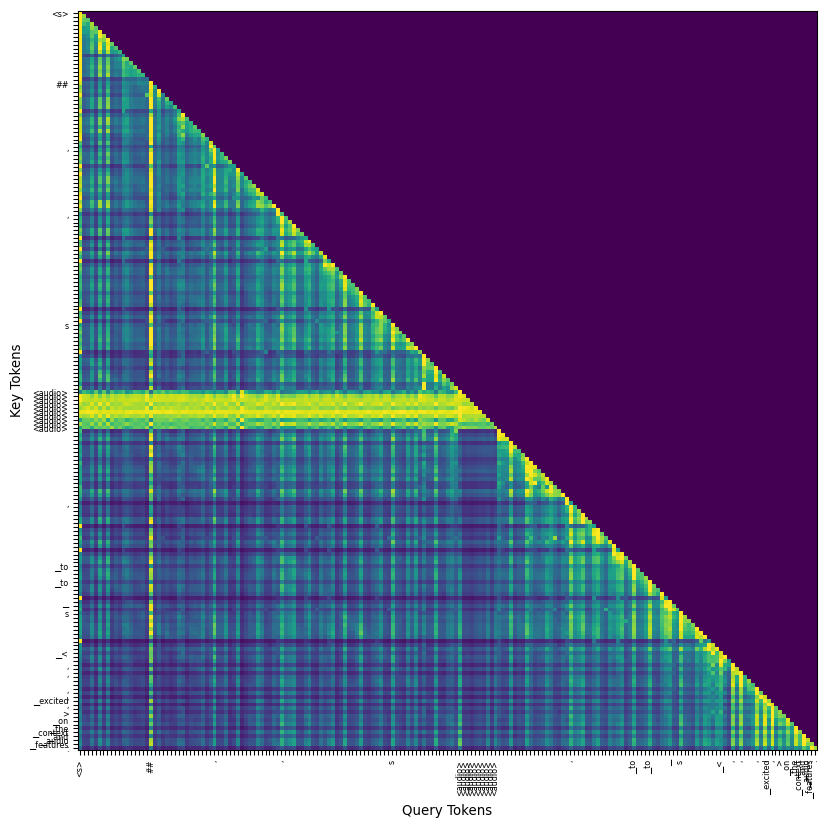

In [65]:


def print_model_attention_weights(dataset_path: str, layer_idx=0, sample_index=0):
    # model, config, processor = utils.get_model(
    #     LANGUAGE_MODEL, LORA_ADAPTER, ACOUSTIC_MODEL, STAGE3_PATH, MmLlamaConcat, model_kwargs = {"output_attention_weights":True}
    # )
    attention_weights, sample = get_attention_weights(
        model, dataset_path, processor, layer_idx, sample_index
    )
    print_attention_weight_matrix(
        attention_weights, sample, config, processor.tokenizer
    )

# print_model_attention_weights(DS_TEST_PATH, layer_idx=2, sample_index=audio_correct_sample_index)
print_model_attention_weights(DS_TEST_PATH, layer_idx=0, sample_index=audio_wrong_sample_index)

Um herauszufinden, welchen Einfluss das Vortraining auf die Verteilung der GEwichte hat, ist hier die Matrix eines Modells, welches direkt auf Stage 3 trainiert wurde.